In [1]:
import pandas as pd
import time
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import missingno as msno

### 1. 데이터 준비

In [2]:
# 데이터 불러오기
adults_icu = pd.read_csv('../outputs/adults_icu2.csv')
intubation_extubation = pd.read_csv('../outputs/intubation_extubation_raw.csv')
# intubation_extubation_stay = pd.read_csv('../outputs/intubation_extubation_stay.csv')

print(f'adults_icu: {adults_icu.shape}')
print(f'intubation_extubation: {intubation_extubation.shape}')
# print(intubation_extubation_stay.shape)

# 시간변수 바꿔주기
intubation_extubation['int_ext_time'] = pd.to_timedelta(intubation_extubation['int_ext_time'])
intubation_extubation['intubationtime'] = pd.to_datetime(intubation_extubation['intubationtime'])
intubation_extubation['extubationtime'] = pd.to_datetime(intubation_extubation['extubationtime'])

intubation_extubation = intubation_extubation.drop(columns=['int_ext_time'])  # int_ext_time 칼럼 필요 X

intubation_extubation.info()

adults_icu: (73181, 13)
intubation_extubation: (11528, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11528 entries, 0 to 11527
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   subject_id       11528 non-null  int64         
 1   hadm_id          11528 non-null  int64         
 2   int_stayid       11528 non-null  int64         
 3   admittime        11528 non-null  object        
 4   intubationtime   11528 non-null  datetime64[ns]
 5   int_itemid       11528 non-null  int64         
 6   int_weight       11528 non-null  float64       
 7   ext_stayid       9941 non-null   float64       
 8   extubationtime   9941 non-null   datetime64[ns]
 9   ext_itemid       9941 non-null   float64       
 10  ext_weight       9941 non-null   float64       
 11  extubationcause  9941 non-null   object        
 12  dischtime        11528 non-null  object        
 13  deathtime        3105 non-null  

### 2. Intubation / Extubation 테이블 전처리
1. Extubation 결측치 처리 (replacement marker 추가)
2. Intubation / Extubation 시간 순서 정렬
3. Intubation to Extubation 시간 차이 계산
4. Reintubation time 계산

##### 작업 함수 정의
- **중요 개념**
  - **데이터 그룹(group)**: 데이터는 'subject_id' (환자 번호)와 'hadm_id' (입원 번호)를 기준으로 그룹화되어 처리됩니다.
  - **단일 행(single-row) 데이터**: 각 데이터 그룹 내에서 삽관-발관 조합이 단 하나만 존재하는 경우입니다.
  - **연속 행(multi-row) 데이터**: 삽관-발관 조합이 두 개 이상 존재하는 데이터 그룹입니다.

##### 데이터 정리 함수
- **`find_pairs(unique_intubations, unique_extubations)`**
  - 삽관 및 발관 시간의 적절한 조합을 찾아 리스트로 반환합니다.
  - 고유한 삽관 시간 목록과 발관 시간 목록을 받아 쌍을 이루는 시간을 찾아내며, 적절한 쌍을 찾지 못한 경우 결측치로 처리합니다.

- **`reformat_multi_row_data_to_dataframe(group, pairs, subject_id, hadm_id)`**
  - 연속 행(multi-row) 데이터를 처리합니다.
  - 다양한 데이터 칼럼을 초기화하고, 삽관 및 발관 시간을 기반으로 데이터를 필터링하여 필요한 정보를 구조화합니다.
  - 'marker' 칼럼을 추가하여 데이터 처리 과정을 표시합니다.

- **`multi_row_formatting(group, subject_id, hadm_id)`**
  - 연속 행(multi-row) 데이터의 재구조화를 담당합니다.
  - `find_pairs` 함수를 사용하여 삽관/발관 이벤트를 재구성하고, `reformat_multi_row_data_to_dataframe`을 통해 재정렬된 데이터를 구조화합니다.

##### 결측치 처리 함수

- **`single_row_imputation(group)`**
  - 단일 행(single-row) 데이터에 대한 결측치 처리를 수행합니다.
  - 'extubationtime'이 결측인 경우, 'deathtime' 또는 'dischtime'을 사용하여 대체하고, 관련 데이터 업데이트를 수행합니다.
  - 결측치 처리 내역을 'marker' 칼럼에 기록합니다.

- **`impute_non_final_rows(group_df)`**
  - 마지막 행을 제외한 데이터프레임의 모든 행에 대해 'extubationtime' 결측치를 다음 행의 'intubationtime'으로 대체합니다.
  - 관련된 다른 열들도 함께 업데이트합니다.

- **`impute_final_row(group_df)`**
  - 데이터프레임의 마지막 행에 대한 결측치 처리를 담당합니다.
  - 'extubationtime'이 결측인 경우, 'deathtime' 또는 'dischtime'으로 대체하고, 관련된 다른 열들도 업데이트합니다.

- **`multi_row_imputation(group_df)`**
  - 연속 행 데이터에 대한 결측치 처리를 수행합니다.
  - `impute_non_final_rows`와 `impute_final_row`를 순차적으로 적용하여 전처리를 진행합니다.

##### 기타 유틸리티 함수

- **`convert_to_datetime(group)`**
  - 데이터프레임 내의 주요 시간 열을 datetime 형식으로 변환합니다.
  - 변환 과정에서 오류가 발생한 경우 NaT로 처리합니다.

- **`combine_dfs_from_lists(singlerow_data_list, multirow_data_list)`**
  - 단일 행 및 연속 행 데이터 리스트를 하나의 데이터프레임으로 결합합니다.
  - 결합된 데이터프레임을 'subject_id', 'hadm_id', 'intubationtime'을 기준으로 정렬합니다.

- **`count_null_extubationtimes(df_list)`**
  - 'extubationtime'의 결측치를 카운트하고, 다양한 유형의 결측치를 분류하여 통계를 제공합니다.

- **`validate_timediff(df_group)`**
  - 삽관 및 발관 시간 간의 시간차가 타당한지 검증합니다.
  - 타당하지 않은 경우, 적절한 조치를 취하고 오류를 'marker'에 기록합니다.

##### 재삽관 시간 계산 함수

- **`get_reintubationtime(df)`**
  - 'reintubationtime' 열을 추가하고, 각 그룹 내에서 다음 행의 'intubationtime'과 현재 행의 'extubationtime' 사이의 시간 차이를 계산합니다.

##### 메인 함수

- **`process_data(df)`**
  - 전체 데이터 처리 과정을 관리하는 메인 함수입니다.
  - 데이터 전처리, 결측치 처리, 시간차 검증 및 재삽관 시간 계산을 수행합니다.
  - 전처리 결과를 요약하여 리포트를 제공합니다.


In [28]:
##### 결측치 처리, 또는 데이터 검증 관련 로그 코드 #####
marker_logs = {
    'missingint' : 'intubationtime null',
    'missingext' : 'extubationtime null',
    'deathtime': 'null extubationtime replaced with deathtime',
    'dischtime': 'null extubationtime replaced with dischtime',
    'death_disch_mismatch' : 'deathtime later than dischtime',
    'next_intubationtime' : 'null extubationtime replaced with next intubationtime',
    'int_ext_mismatch' : 'intubationtime later than extubationtime',
    'admittime' : 'replaced intubationtime with admittime'
}

##### 데이터 정리 함수 #####

# # 삽관/발관 이벤트가 1쌍 존재하는 그룹의 칼럼 구조 변환 (i.e., 'marker' 칼럼 추가)
# def modify_single_row_df(group):
#     group['marker'] = None  # 초기화 (결측치 imputation 시 사용될 예정)
#     return group


# 삽관/발관 이벤트가 1쌍 존재하는 데이터의 결측치 처리
def single_row_imputation(group, imputation=False):
    # extubationtime 결측치 deathtime, dischtime 값으로 대체
    condition_deathtime = group['extubationtime'].isnull() & group['deathtime'].notnull()
    condition_dischtime = group['extubationtime'].isnull() & group['deathtime'].isnull() & group['dischtime'].notnull()

    group.loc[condition_deathtime, 'extubationtime'] = group.loc[condition_deathtime, 'deathtime']
    group.loc[condition_dischtime, 'extubationtime'] = group.loc[condition_dischtime, 'dischtime']

    # 'ext_stayid', 'ext_itemid', 'ext_weight' 결측치 'int_stayid', 'int_itemid', 'int_weight' 로 대체
    group.loc[condition_deathtime | condition_dischtime, 'ext_stayid'] = group.loc[condition_deathtime | condition_dischtime, 'int_stayid']
    group.loc[condition_deathtime | condition_dischtime, 'ext_itemid'] = group.loc[condition_deathtime | condition_dischtime, 'int_itemid']
    group.loc[condition_deathtime | condition_dischtime, 'ext_weight'] = group.loc[condition_deathtime | condition_dischtime, 'int_weight']

    # marker 칼럼 생성
    group.loc[condition_deathtime, 'marker'] = marker_logs['deathtime']
    group.loc[condition_dischtime, 'marker'] = marker_logs['dischtime']

    # print(f'marker_logs type: {type(group.marker)}')

    return group


# 정렬 알고리즘 v3
def find_pairs(unique_intubations, unique_extubations):
    ''' 
    정렬 알고리즘 v3: 삽관 및 발관 시간 쌍 찾기
    이 함수는 고유한 삽관 시간 목록과 고유한 발관 시간 목록을 입력으로 받아
    삽관 시간과 발관 시간의 쌍을 찾습니다.

    매개변수:
    unique_intubations (list): 고유한 삽관 시간 목록
    unique_extubations (list): 고유한 발관 시간 목록

    반환값:
    list: 삽관 시간과 발관 시간의 쌍 목록
            (intubation_time, extubation_time) 형식의 튜플로 구성됨
            쌍을 찾지 못한 경우 (intubation_time, None) 또는 (None, extubation_time)으로 표시
    '''
    unique_intubations.sort()
    unique_extubations.sort()

    pairs = []   # 쌍을 저장할 빈 목록 생성
    int_index, ext_index = 0, 0   # 삽관 및 발관 시간 목록에서 현재 위치를 추적할 인덱스 변수

    # 두 목록 중 하나라도 끝에 도달할 때까지 반복
    while int_index < len(unique_intubations) or ext_index < len(unique_extubations):
        # 현재 삽관 및 발관 시간을 가져오고, 목록 끝에 도달한 경우 None 할당
        int_time = unique_intubations[int_index] if int_index < len(unique_intubations) else None
        ext_time = unique_extubations[ext_index] if ext_index < len(unique_extubations) else None

        # 케이스 1: 삽관 시간이 더 이상 없음
        if int_time is None:
            pairs.append((None, ext_time))
            ext_index += 1
        # 케이스 2: 발관 시간이 삽관 시간과 일치하거나 더 이상 발관 시간이 없음
        elif ext_time is None or ext_time >= int_time:
            # 발관 시간이 현재 삽관 시간에 유효한지 확인
            if ext_time is None or (int_index + 1 < len(unique_intubations) and ext_time >= unique_intubations[int_index + 1]):
                pairs.append((int_time, None))   # 쌍에 (삽관 시간, None) 추가
            else:
                pairs.append((int_time, ext_time))   # 쌍에 (삽관 시간, 발관 시간) 추가
                ext_index += 1   # 다음 발관 시간으로 이동
            int_index += 1   # 다음 삽관 시간으로 이동
        # 케이스 3: 발관 시간이 삽관 시간보다 이전임
        else:
            pairs.append((None, ext_time))   # 쌍에 (None, 발관 시간) 추가
            ext_index += 1   # 다음 발관 시간으로 이동

    return pairs


# 연속행 데이터의 재구조화
def reformat_multi_row_data_to_dataframe(group, pairs, subject_id, hadm_id):
    # # Check if 'admittime' is missing in all rows of the group
    # if group['admittime'].isnull().all():
    #     # Handle the case as needed, e.g., return an empty DataFrame or raise an exception
    #     print(f"{subject_id}, {hadm_id} Error: 'admittime' is missing for all rows in the group.")

    formatted_data_list = []

    for pair in pairs:
        intubation_time, extubation_time = pair

        # 칼럼 초기화
        formatted_row_data = {col: None for col in ['subject_id', 'hadm_id', 'int_stayid',
                                        'admittime', 'intubationtime', 'int_itemid', 'int_weight',
                                        'ext_stayid', 'extubationtime', 'ext_itemid', 'ext_weight',
                                        'extubationcause', 'dischtime', 'deathtime', 'marker']}
        
        # intubationtime과 짝지어져 입력될 데이터
        int_row_cols = ['int_stayid', 'admittime', 'intubationtime', 'int_itemid', 'int_weight', 'dischtime', 'deathtime']

        # extubationtime과 짝지어져 입력될 데이터
        ext_row_cols = ['ext_stayid', 'admittime', 'extubationtime', 'ext_itemid', 'ext_weight', 'extubationcause', 'dischtime', 'deathtime']

        # print('========================================================================')
        # print(f'INTUBATION TIME: {intubation_time} --> EXTUBATION TIME: {extubation_time}')
        # print(f'format_multi_row_data ON sub_id: {subject_id}, hadm_id: {hadm_id}...')

        # 삽관/발관시간 필터링
        matching_rows = group[(group['intubationtime'] == intubation_time) & 
                            (group['extubationtime'] == extubation_time)]

        if not matching_rows.empty:
            # Use data from the matching row if available
            matching_data = matching_rows.iloc[0].to_dict()
            formatted_row_data.update(matching_data)
            # print('DETECTED MATCHING ROW.')

        else:
            # intubationtime이 있는 경우 데이터 입력
            if not group[group['intubationtime'] == intubation_time].empty:
                # print(f'DETECTED INTUBATIONTIME: {intubation_time}')
                intubation_data = group[group['intubationtime'] == intubation_time].iloc[0]
                for col in int_row_cols:
                    formatted_row_data[col] = intubation_data[col]

            # extubationtime만 있는 경우 데이터 입력
            if extubation_time is not None and not group[group['extubationtime'] == extubation_time].empty:
                extubation_data = group[group['extubationtime'] == extubation_time].iloc[0]
                for col in ext_row_cols:
                    formatted_row_data[col] = extubation_data[col]
            else:
                # extubationtime이 결측치일 경우, admittime, dischtime, deathtime을 제외한 다른 열은 None으로 입력
                cols_to_exclude = ['admittime', 'dischtime', 'deathtime']
                for col in [c for c in ext_row_cols if c not in cols_to_exclude]:
                    formatted_row_data[col] = None
        
        # 'subject_id', 'hadm_id' 값 입력
        formatted_row_data['subject_id'] = subject_id
        formatted_row_data['hadm_id'] = hadm_id

        # print(f'FORMATTED ROW DATA: {formatted_row_data}, LENGTH: {len(formatted_row_data)}')
        formatted_data_list.append(formatted_row_data)
        # print(f'formatted_data_list: {type(formatted_data_list)}')

    formatted_dataframe = pd.DataFrame(formatted_data_list)   # 재정렬된 dataframe을 반환
    return formatted_dataframe


# 연속행 데이터의 시간대별 재졍렬 및 구조화
def multi_row_formatting(group, subject_id, hadm_id):

    # (subject_id, hadm_id) 그룹 내에서 고유한 intubationtime, extubationtime 값 추출
    unique_intubations = list(group['intubationtime'].dropna().unique())
    unique_extubations = list(group['extubationtime'].dropna().unique())

    # Pairing (sorting algorithm)
    pairs = find_pairs(unique_intubations, unique_extubations)  # result: list of tuples

    # # debugging code
    # print(f'DETECTED {len(pairs)} UNIQUE PAIRS')
    # for i, pair in enumerate(pairs):   # enumerate list
    #     print(f'PAIR {i} ({type(pair)}): {pair}')    # tuple     

    # 재정렬된 데이터 구조화
    reformatted_multirow_dataframe = reformat_multi_row_data_to_dataframe(group, pairs, subject_id, hadm_id)

    return reformatted_multirow_dataframe   # 구조화된 데이터


##### 결측치 처리 함수 #####

# 마지막행을 제외한 행의 결측치 처리
def impute_non_final_rows(group_df):    
    for i in range(len(group_df) - 1):
        # 'extubationtime' null 값 확인
        if pd.isnull(group_df.iloc[i]['extubationtime']):
            # # Debugging: Print values before assignment
            # print(f"Before: Row {i}, ext_itemid: {group_df.at[i, 'ext_itemid']}, ext_weight: {group_df.at[i, 'ext_weight']}")

            # 다음 행의 intubationtime으로 extubationtime 값 대체
            group_df.at[i, 'extubationtime'] = group_df.iloc[i + 1]['intubationtime']
            # 'marker' 업데이트
            group_df.at[i, 'marker'] = marker_logs['next_intubationtime']

            # 다음행의 int_stayid, int_itemid, int_weight 값으로 현재 행의 ext_stayid, ext_itemid, ext_weight 값 대체
            group_df.at[i, 'ext_stayid'] = group_df.iloc[i + 1]['int_stayid']
            group_df.at[i, 'ext_itemid'] = group_df.iloc[i + 1]['int_itemid']
            group_df.at[i, 'ext_weight'] = group_df.iloc[i + 1]['int_weight']

            # # Debugging: Print values after assignment
            # print(f"After: Row {i}, ext_itemid: {group_df.at[i, 'ext_itemid']}, ext_weight: {group_df.at[i, 'ext_weight']}")

    return group_df


# 마지막행의 결측치 처리 및 marker 업데이트
def impute_final_row(group_df):
    last_row_idx = len(group_df) - 1
    if pd.isnull(group_df.iloc[last_row_idx]['extubationtime']):
        if pd.notnull(group_df.iloc[last_row_idx]['deathtime']):
            group_df.iloc[last_row_idx, group_df.columns.get_loc('extubationtime')] = group_df.iloc[last_row_idx]['deathtime']
            group_df.iloc[last_row_idx, group_df.columns.get_loc('marker')] = marker_logs['deathtime']
        elif pd.notnull(group_df.iloc[last_row_idx]['dischtime']):
            group_df.iloc[last_row_idx, group_df.columns.get_loc('extubationtime')] = group_df.iloc[last_row_idx]['dischtime']
            group_df.iloc[last_row_idx, group_df.columns.get_loc('marker')] = marker_logs['dischtime']

        # 이번 행의 int_stayid, int_itemid, int_weight 값으로 같은 행의 ext_stayid, ext_itemid, ext_weight 값 대체
        group_df.iloc[last_row_idx, group_df.columns.get_loc('ext_stayid')] = group_df.iloc[last_row_idx]['int_stayid']
        group_df.iloc[last_row_idx, group_df.columns.get_loc('ext_itemid')] = group_df.iloc[last_row_idx]['int_itemid']
        group_df.iloc[last_row_idx, group_df.columns.get_loc('ext_weight')] = group_df.iloc[last_row_idx]['int_weight']

    return group_df


# 연속행 데이터의 결측치 처리
def multi_row_imputation(group_df, impute_null=False):
    # 마지막행을 제외한 데이터 처리
    group_df_non_final_imputed = impute_non_final_rows(group_df)
    # 마지막행 데이터 처리
    preprocessed_group_df = impute_final_row(group_df_non_final_imputed)

    return preprocessed_group_df


##### 기타 유틸리티 함수 #####

def check_null_and_mark(df, column):
    pass


def convert_to_datetime(group):
    with warnings.catch_warnings():   
        warnings.simplefilter("ignore")
        # 'intubationtime' datetime 변환
        if group['intubationtime'].dtype != 'datetime64[ns]':
            group['intubationtime'] = pd.to_datetime(group['intubationtime'], errors='coerce')

        # 'extubationtime' datetime 변환
        if group['extubationtime'].dtype != 'datetime64[ns]':
            group['extubationtime'] = pd.to_datetime(group['extubationtime'], errors='coerce')
        
        # 'deathtime' datetime 변환
        if group['deathtime'].dtype != 'datetime64[ns]':
            group['deathtime'] = pd.to_datetime(group['deathtime'], errors='coerce')

        # 'dischtime' datetime 변환
        if group['dischtime'].dtype != 'datetime64[ns]':
            group['dischtime'] = pd.to_datetime(group['dischtime'], errors='coerce')

    return group


def combine_dfs_from_lists(singlerow_data_list, multirow_data_list):
    # 전처리 과정에서 생성된 데이터 리스트를 DataFrame으로 변환
    combined_list = singlerow_data_list + multirow_data_list

    # 복수의 DataFrame을 하나의 DataFrame으로 결합
    combined_df = pd.concat(combined_list, ignore_index=True)

    # 'subject_id', 'hadm_id', 'imputationtime' 순으로 정렬 (ascending=True)
    combined_df = combined_df.sort_values(by=['subject_id', 'hadm_id', 'intubationtime', 'extubationtime'], ascending=True)

    return combined_df


# Debugging, troubleshooting code
def count_null_extubationtimes(df_list):
    # 시간 순서가 재정렬된 데이터 중에서 결측치를 카운트하는 함수
    # 참고: single row final exttime null과 multi row final exttime null는 같은 로직으로 결측치를 처리함 (deathtime, dischtime 대체)

    # Count 초기화
    null_count_dict = {
        'single row final exttime null': 0,  # 단일 케이스에서 exttime이 결측
        'multi row final exttime null': 0,   # 복수 케이스에서 최종 exttime이 결측
        'multi row middle exttime null': 0   # 복수 케이스에서 중간 exttime이 결측
    }

    for df in df_list:
        # single row 데이터 확인
        if len(df) == 1:
            if pd.isnull(df['extubationtime'].iloc[0]):
                null_count_dict['single row final exttime null'] += 1

        # multi row 데이터 확인
        elif len(df) > 1:
            # 최종 null 값 확인
            if pd.isnull(df['extubationtime'].iloc[-1]):
                null_count_dict['multi row final exttime null'] += 1

            # 중간 null 값 확인
            if df[:-1]['extubationtime'].isnull().any():
                null_count_dict['multi row middle exttime null'] += 1

    return null_count_dict


# intubationtime과 extubationtime의 시간차 검증 코드
def validate_timediff(df, impute_null):

    # 'subject_id'과 'hadm_id'로 그룹
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    for (subject_id, hadm_id), group in tqdm(grouped_df, desc="\tProcessing Time Diff Validation"):
        # print(f'\tVALIDATING subject_id: {subject_id}, hadm_id: {hadm_id}...')

        # timestamps 데이터타입 변환
        group['admittime'] = pd.to_datetime(group['admittime'], errors='coerce')
        group['extubationtime'] = pd.to_datetime(group['extubationtime'], errors='coerce')
        group['dischtime'] = pd.to_datetime(group['dischtime'], errors='coerce')
        group['deathtime'] = pd.to_datetime(group['deathtime'], errors='coerce')      

        # 삽관/발관 시간 처리
        # 'extubationtime'과 'intubationtime' 시간차 계산
        time_diff = group['extubationtime'] - group['intubationtime']

        # 시간차가 음수인 데이터 확인
        if any(time_diff.dt.total_seconds() < 0):
            # print('NEGATIVE EVENT DETECTED.')
            # 단일행 데이터
            if len(group) == 1:
                # 'extubationtime'이 'admittime'보다 빠른 경우 
                df.at[group.index[0], 'marker'] = marker_logs['int_ext_mismatch']   # add marker
                if group['admittime'].iloc[0] < group['extubationtime'].iloc[0]:
                    if impute_null:
                        df.loc[group.index, 'intubationtime'] = group['admittime'].iloc[0]
                        df.at[group.index[0], 'marker'] = marker_logs['int_ext_mismatch'], marker_logs['admittime']
                        # print('SINGLE ROW EVENT TAKEN CARE OF.')
                #     else:
                #         df.at[group.index[0], 'marker'] = marker_logs['int_ext_mismatch']

                # # 대체 가능한 값이 없을 때 마커만 기록
                # else:
                #     df.at[group.index[0], 'marker'] = marker_logs['int_ext_mismatch']
            else:
                # 정렬 알고리즘 작동 후에 해당 케이스는 없는게 정상인데.. 만약 있다면 로깅만.
                # print('MULTI ROW EVENT DETECTED. ')
                df.at[group.index[0], 'marker'] = marker_logs['int_ext_mismatch']

        
        # 퇴원/사망 시간 처리
        # 퇴원시간 - 사망시간 시간차 계산
        disch_death_time_diff = group['dischtime'] - group['deathtime']

        # 시간차가 음수인 데이터 확인
        if any(disch_death_time_diff.dt.total_seconds() < 0):
            for i in group.index:
                # 기존의 'marker' 값 확인
                if pd.notna(df.at[i, 'marker']):
                    # 기존 값이 존재할 경우, 새로운 값 추가한 튜플 생성
                    current_marker = df.at[i, 'marker']
                    if isinstance(current_marker, tuple):
                        # 기존값이 튜플일 경우, 새로운 값을 기존 튜플에 추가
                        df.at[i, 'marker'] = current_marker + (marker_logs['death_disch_mismatch'],)
                    else:
                        # 기존값이 튜플이 아닐 경우, 새로운 값과 함께 새로운 튜플 생성
                        df.at[i, 'marker'] = (current_marker, marker_logs['death_disch_mismatch'])
                else:
                    # 기존값이 없을 경우, 마커 스트링 추가
                    df.at[i, 'marker'] = marker_logs['death_disch_mismatch']

    return df


# 결과 리포트하는 함수
def get_report(df, original_shape):

    subject_count =  len(df.subject_id.unique()) # 고유 환자 수
    hadm_count =  len(df.hadm_id.unique()) # 고유 입원 케이스 수

    # 카운터 초기화
    errors = {key: 0 for key in marker_logs.keys()}

    # 'marker'가 있는 데이터 확인
    for marker in df[df['marker'].notnull()]['marker']:
        if isinstance(marker, tuple):
            # 마커가 튜플인 경우, 튜플 안의 개별 값을 카운트
            for error in marker:
                for key in marker_logs.keys():
                    if marker_logs[key] in error:
                        errors[key] += 1
        else:
            # 마커가 개별 스트링인 경우 카운트
            for key in marker_logs.keys():
                if marker_logs[key] in marker:
                    errors[key] += 1

    total_marker_count = sum(errors.values())   # 전체 마커수 카운트

    # timedelta -> number of days
    reintubation_days = df['reintubationtime'].dt.days
    reintubation_count = (df.reintubationtime.dt.days > 0).sum()

    print('====================================REPORT====================================')
    print(f'ORIGINAL DATA SHAPE: {original_shape}')
    print(f'PROCESSED DATA SHAPE: {df.shape}')
    print(f'MISSING VALUES:')
    print(df.isna().sum())


    print(f'NUM UNIQUE SUBJECTS: {subject_count}')
    print(f'NUM UNIQUE HOSPITAL ADMISSIONS: {hadm_count}')
    # print(f'NUM REINTUBATION EVENTS: {reintubation_count} / {df.shape[0]} ({round(reintubation_count/df.shape[0] * 100, 2)}%)')
    # print(f'NUM DATA ERRORS: {total_marker_count} / {df.shape[0]} ({round(total_marker_count / df.shape[0] * 100, 2)} %)')
    # for error_type, count in errors.items():
    #     print(f"\t{error_type} ERRORS: {count} / {total_marker_count} instances ({round(count/total_marker_count, 2)} %)")


    # 빈도 분포 그래프 (로그변환) 그리기  (0값이 너무 많아서 로그 변환 필요)
    plt.figure(figsize=(10, 6))
    plt.hist(reintubation_days, bins=range(int(reintubation_days.min()), int(reintubation_days.max()) + 2), align='left', color='blue', edgecolor='black', log=True)
    plt.xlabel('Days')
    plt.ylabel('Frequency (Log Scale)')
    plt.title('Frequency Distribution of Reintubation Time (Log Scale)')

    tick_interval = 5  # x tick 간격 설정
    plt.xticks(range(int(reintubation_days.min()), int(reintubation_days.max()) + 1, tick_interval))
    plt.xticks(rotation=45) 

    plt.grid(axis='y', alpha=0.75)
    plt.show()

def enter_log():
    pass


##### 재삽관 시간 계산 함수 #####

def get_reintubationtime(df):
    # DataFrame을 'subject_id', 'hadm_id', 'intubationtime' 으로 정렬
    df = df.sort_values(by=['subject_id', 'hadm_id', 'intubationtime'])

    # 'reintubationtime' 값을 0으로 초기화
    df['reintubationtime'] = pd.Timedelta(seconds=0)

    # 'subject_id'과 'hadm_id'으로 그룹
    grouped = df.groupby(['subject_id', 'hadm_id'])

    # 개별 그룹 순회
    for name, group in grouped:
        # 1째 행과 마지막행을 제외한 행의 reintubation 값 계산
        if len(group) > 2:
            for i in range(1, len(group) - 1):
                current_idx = group.index[i]
                next_idx = group.index[i + 1]

                # 'reintubationtime' 계산
                df.at[current_idx, 'reintubationtime'] = df.at[next_idx, 'intubationtime'] - df.at[current_idx, 'extubationtime']

    reintubation_df = df.reset_index(drop=True)

    return reintubation_df


##### 메인 함수 #####

def process_data(df, impute_null=False):
    original_shape = df.shape
    start_time = time.time()   # 소요시간 계산
    print('DATA PROCESSING...')

    # 'int_ext_time' column 확인 후 삭제
    if 'int_ext_time' in df.columns:
        df = df.drop('int_ext_time', axis=1)
    
    # 'marker' column 생성
    df['marker'] = None

    # subject_id와 hadm_id로 그룹화
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    preprocessed_single_row_list = []
    reformatted_multirow_dataframe_list = []

    # 데이터 1차 정리: single row processing, multirow reformatting
    for (subject_id, hadm_id), group in tqdm(grouped_df, desc="\tProcessing Groups"):
        # print(f'\tPROCESSING subject_id: {subject_id}, hadm_id: {hadm_id}...')

        # 시간변수 Datetime 변환 (확실히 하기 위해)
        group = convert_to_datetime(group)

        # single row processing
        # 해당 그룹(hadm_id)에 intubation 이벤트가 하나만 있는 경우 (즉, 순서 검증이 필요 없는 경우)
        if group['intubationtime'].count() == 1:
            group = single_row_imputation(group) if impute_null else group  # Impute if needed, else keep as is
            preprocessed_single_row_list.append(group)


        # 해당 그룹(hadm_id) 안에 여러 개의 intubation 이벤트가 있는 경우 (즉, 순서 검증이 필요한 경우)
        elif group['intubationtime'].count() > 1:
            # multi-row pairing, dataframe formatting
            reformatted_multirow_dataframe = multi_row_formatting(group, subject_id, hadm_id)
            reformatted_multirow_dataframe_list.append(reformatted_multirow_dataframe)  # list of dfs


    # 데이터 2차 정리: reformatted multirow data 처리
    ## 1) 새로 발생한 single_row 처리
    ## 2) multirow 결측치 처리
            
    preprocessed_multirow_data_list = []
    for group_df in tqdm(reformatted_multirow_dataframe_list, desc="\tProcessing Multi-Row Data"):
        # 정리된 DataFrame 중에도 single row event 가 존재할 수 있음. 
        ## 이 경우, 똑같이 single_row_imputation을 사용.
        if group_df['intubationtime'].count() == 1:
            group_df = single_row_imputation(group_df) if impute_null else group_df  # Impute if needed, else keep as is
            preprocessed_single_row_list.append(group_df)
        
        else:
            group_df = multi_row_imputation(group_df) if impute_null else group_df
            preprocessed_multirow_data_list.append(group_df)

    # 전처리 완료된 데이터프레임 결합
    preprocessed_df = combine_dfs_from_lists(preprocessed_single_row_list, preprocessed_multirow_data_list)
    print('\tPREPROCESSING COMPLETE.')

    # intubation/extubation 시간차 검증
    print('\tRUNNING TIME DIFF VALIDATION...')
    validated_df = validate_timediff(preprocessed_df, impute_null)
    print('\tVALIDATION COMPLETE.')


    # extubation - intubation 시간차 계산
    validated_df['intubationtime'] = pd.to_datetime(validated_df['intubationtime'], errors='coerce')
    validated_df['extubationtime'] = pd.to_datetime(validated_df['extubationtime'], errors='coerce')
    validated_df['int_ext_timediff'] = validated_df['extubationtime'] - validated_df['intubationtime']

    # reintubationtime 계산
    print('\tCOMPUTING reintubationtime...')
    reintubation_df = get_reintubationtime(validated_df)

    print('PROCESSING COMPLETE.')

    # 전처리 리포트 출력
    get_report(reintubation_df, original_shape)

    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))


    return reintubation_df



    



DATA PROCESSING...


	Processing Multi-Row Data: 100%|██████████| 1967/1967 [00:00<00:00, 51324.11it/s]
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_17212/2376879772.py:271: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(combined_list, ignore_index=True)
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_17212/2376879772.py:271: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(combined_list, ignore_index=True)


	PREPROCESSING COMPLETE.
	RUNNING TIME DIFF VALIDATION...


	Processing Time Diff Validation: 100%|██████████| 7087/7087 [00:05<00:00, 1327.17it/s]


	VALIDATION COMPLETE.
	COMPUTING reintubationtime...
PROCESSING COMPLETE.
====================================REPORT====================================
ORIGINAL DATA SHAPE: (11528, 15)
PROCESSED DATA SHAPE: (9747, 17)
MISSING VALUES:
subject_id             0
hadm_id                0
int_stayid          1302
admittime              0
intubationtime      1302
int_itemid          1302
int_weight          1302
ext_stayid          2390
extubationtime      2390
ext_itemid          2390
ext_weight          2390
extubationcause     2390
dischtime              0
deathtime           7148
marker              9221
int_ext_timediff    3692
reintubationtime     554
dtype: int64
NUM UNIQUE SUBJECTS: 6709
NUM UNIQUE HOSPITAL ADMISSIONS: 7087


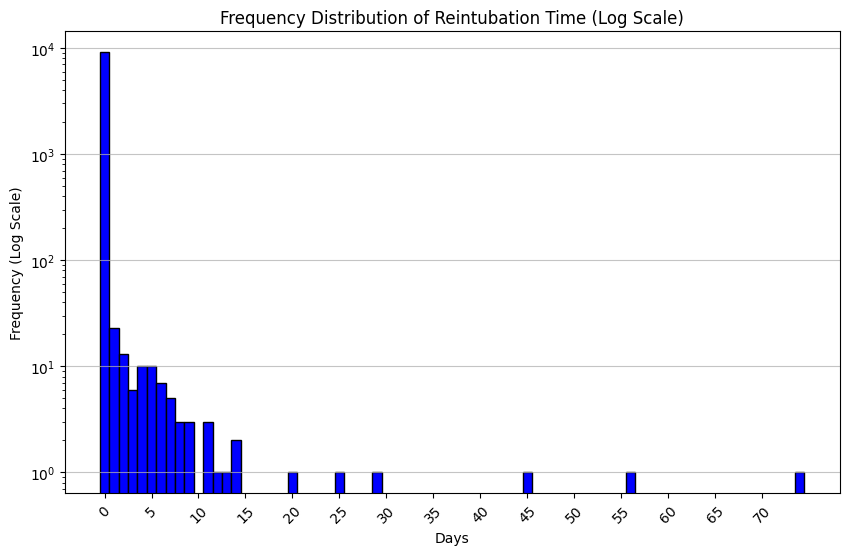

--- RUNTIME: 14.18 seconds ---


In [29]:
reintubation_df_full = process_data(intubation_extubation)


In [6]:
reintubation_df_full.columns

Index(['subject_id', 'hadm_id', 'int_stayid', 'admittime', 'intubationtime',
       'int_itemid', 'int_weight', 'ext_stayid', 'extubationtime',
       'ext_itemid', 'ext_weight', 'extubationcause', 'dischtime', 'deathtime',
       'marker', 'int_ext_timediff', 'reintubationtime'],
      dtype='object')

In [25]:
int_ext_group = intubation_extubation.groupby(['subject_id', 'hadm_id'])

for (subject_id, hadm_id), group in int_ext_group:
    if group['admittime'].isnull().sum() > 0:
        # Handle the case as needed, e.g., return an empty DataFrame or raise an exception
        print(f"{subject_id}, {hadm_id} Error: 'admittime' is missing for rows in the group.")

In [26]:
intubation_extubation[intubation_extubation.admittime.isna()]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker


In [30]:
reintubation_df_full[reintubation_df_full.subject_id == 19960105]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,int_ext_timediff,reintubationtime
9701,19960105,20796727,31681448.0,2146-08-18 19:57:00,2146-08-19 04:35:00,224385.0,61.2,31681448.0,2146-08-20 11:42:00,227194.0,61.2,Planned Extubation,2146-08-29 17:19:00,NaT,None,1 days 07:07:00,0 days
9702,19960105,27292691,31512322.0,2147-08-06 18:06:00,2147-08-09 01:10:00,224385.0,56.8,NaN,NaT,NaN,NaN,None,2147-08-23 14:16:00,NaT,None,NaT,0 days
9703,19960105,27292691,31512322.0,2147-08-06 18:06:00,2147-08-15 12:40:00,224385.0,56.8,NaN,NaT,NaN,NaN,None,2147-08-23 14:16:00,NaT,None,NaT,0 days


In [31]:
reintubation_df_full[reintubation_df_full.subject_id == 10004401]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,int_ext_timediff,reintubationtime
2,10004401,27939719,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,NaT,NaN,NaN,NaN,2144-04-13 17:31:00,NaT,None,NaT,0 days
3,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT,None,2 days 17:30:00,0 days
4,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,NaT,NaN,NaN,None,2144-02-06 11:45:00,NaT,None,NaT,0 days


In [32]:
reintubation_df_full[reintubation_df_full.subject_id == 19969918]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,int_ext_timediff,reintubationtime
9713,19969918,29544887,31213286.0,2186-01-15 23:00:00,2186-01-16 20:29:00,224385.0,68.0,NaN,NaT,NaN,NaN,None,2186-02-07 17:04:00,NaT,None,NaT,0 days 00:00:00
9714,19969918,29544887,31213286.0,2186-01-15 23:00:00,2186-01-16 21:10:00,224385.0,68.0,31213286.0,2186-01-18 09:56:00,227194.0,68.0,Planned Extubation,2186-02-07 17:04:00,NaT,None,1 days 12:46:00,9 days 08:34:00
9715,19969918,29544887,35223685.0,2186-01-15 23:00:00,2186-01-27 18:30:00,224385.0,68.0,NaN,NaT,NaN,NaN,None,2186-02-07 17:04:00,NaT,None,NaT,0 days 00:00:00


In [33]:
reintubation_df_full[reintubation_df_full.admittime.isna()]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,int_ext_timediff,reintubationtime


In [34]:
reintubation_df_full.isna().sum()

subject_id             0
hadm_id                0
int_stayid          1302
admittime              0
intubationtime      1302
int_itemid          1302
int_weight          1302
ext_stayid          2390
extubationtime      2390
ext_itemid          2390
ext_weight          2390
extubationcause     2390
dischtime              0
deathtime           7148
marker              9221
int_ext_timediff    3692
reintubationtime     554
dtype: int64

<Axes: >

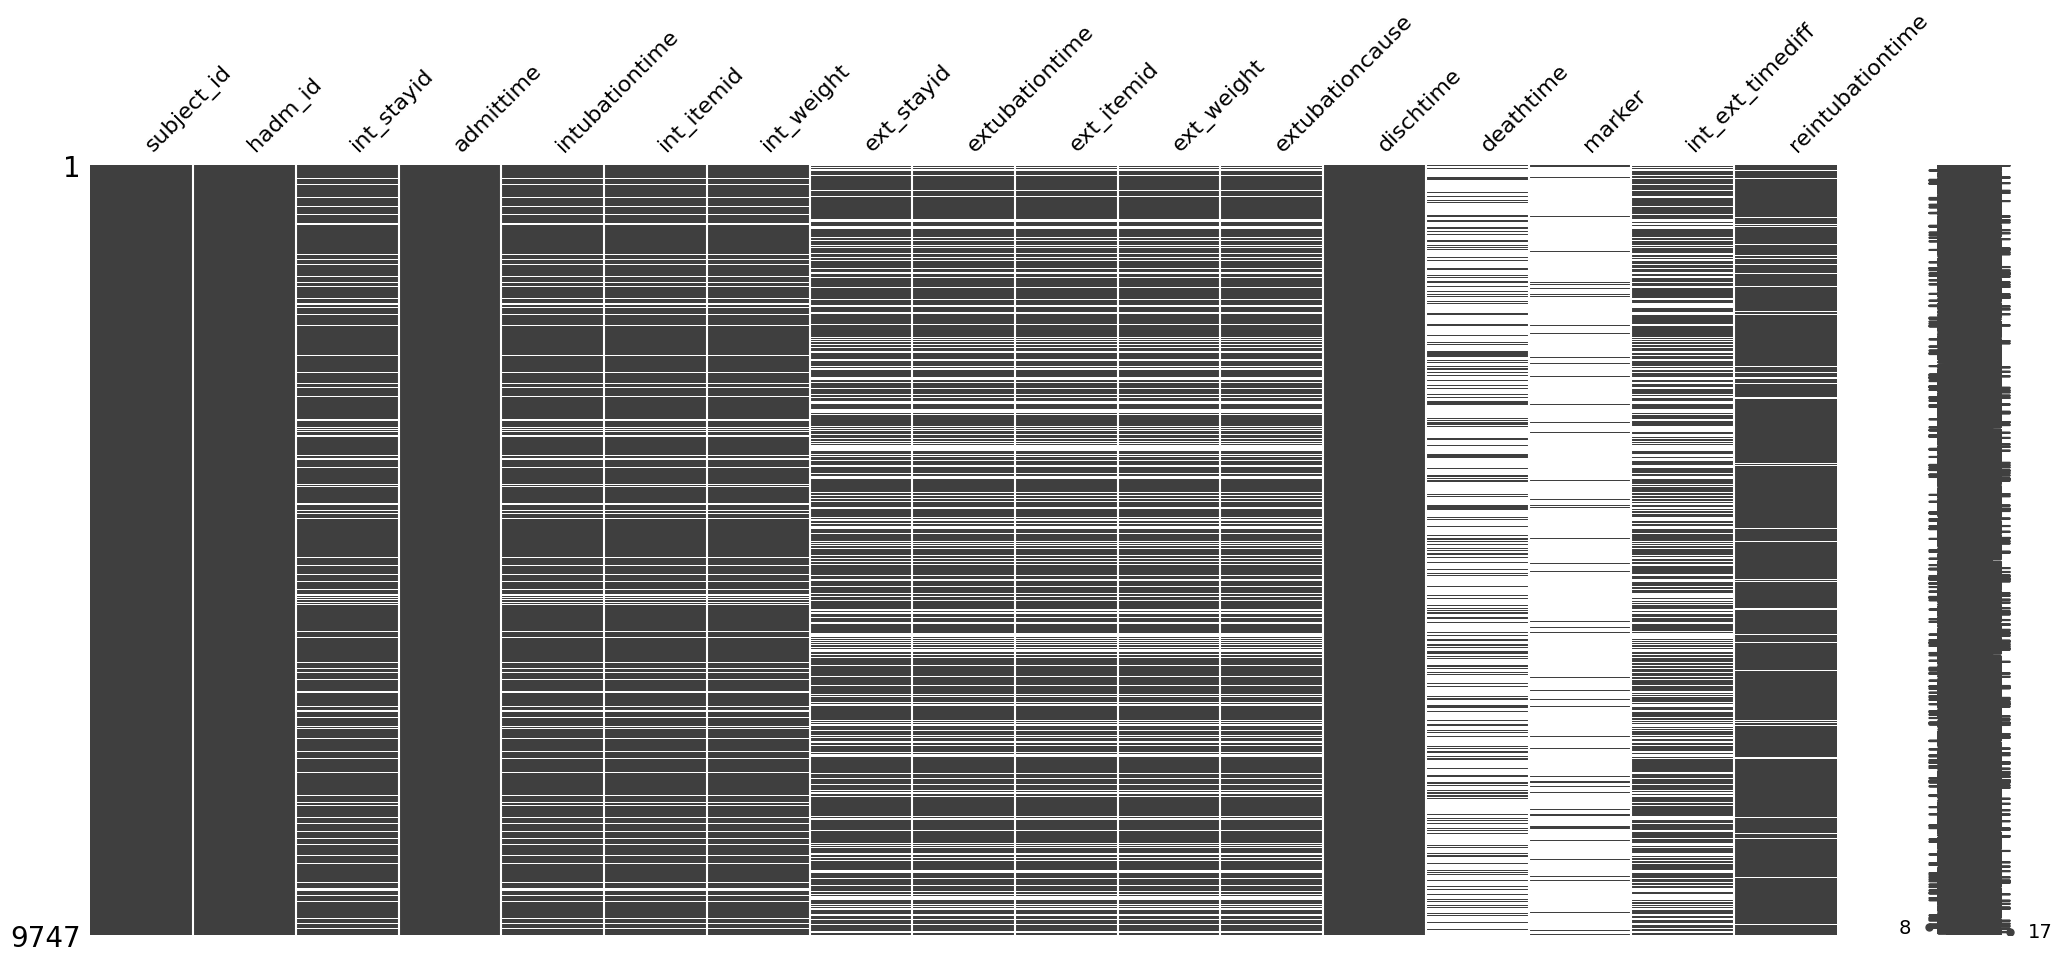

In [35]:
msno.matrix(reintubation_df_full)

In [16]:
reintubation_df_grouped = reintubation_df_full.groupby(['subject_id', 'hadm_id'])
ext_null_count = 0
single_row_group_count = 0
for (subject_id, hadm_id), group in reintubation_df_grouped:
    if len(group) == 1: # single row
        single_row_group_count += 1
        ext_null_count += group.extubationtime.isna().sum()

print(single_row_group_count)
print(ext_null_count)


5346
1433


In [18]:
reintubation_df_grouped = reintubation_df_full.groupby(['subject_id', 'hadm_id'])
int_null_count = 0
single_row_group_count = 0
for (subject_id, hadm_id), group in reintubation_df_grouped:
    if len(group) == 1: # single row
        single_row_group_count += 1
        int_null_count += group.intubationtime.isna().sum()

print(single_row_group_count)
print(int_null_count)


5346
0


In [15]:
reintubation_df_full[reintubation_df_full.intubationtime.isna()]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,int_ext_timediff,reintubationtime
16,10020740,23831430,NaN,None,NaT,NaN,NaN,35026312.0,2150-03-12 18:15:00,227194.0,102.5,Planned Extubation,NaT,NaT,None,NaT,NaT
17,10020740,23831430,NaN,None,NaT,NaN,NaN,35044342.0,2150-03-19 11:05:00,227194.0,103.0,Planned Extubation,NaT,NaT,None,NaT,0 days
22,10024982,25154057,NaN,None,NaT,NaN,NaN,37919901.0,2203-09-28 17:00:00,227194.0,79.1,Planned Extubation,NaT,NaT,None,NaT,0 days
25,10027602,28166872,NaN,None,NaT,NaN,NaN,32391858.0,2201-11-07 13:53:00,227194.0,64.0,Planned Extubation,NaT,NaT,None,NaT,0 days
56,10085667,27382550,NaN,None,NaT,NaN,NaN,36886741.0,2192-12-14 14:36:00,227194.0,95.3,Planned Extubation,NaT,NaT,None,NaT,0 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9339,19965802,21104872,NaN,None,NaT,NaN,NaN,34618456.0,2122-01-04 15:50:00,227194.0,101.3,Planned Extubation,NaT,NaT,None,NaT,0 days
9350,19975796,25848942,NaN,None,NaT,NaN,NaN,31651964.0,2148-12-03 10:33:00,227194.0,72.0,Planned Extubation,NaT,NaT,None,NaT,0 days
9362,19989918,20256395,NaN,None,NaT,NaN,NaN,35582926.0,2175-09-26 16:00:00,227194.0,124.4,Planned Extubation,NaT,NaT,None,NaT,0 days
9366,19995595,21784060,NaN,None,NaT,NaN,NaN,34670930.0,2126-10-30 14:26:00,227194.0,94.7,Planned Extubation,NaT,NaT,None,NaT,0 days


In [36]:
reintubation_df_full.to_csv('../outputs/alignment_df_raw_new.csv')